<a href="https://colab.research.google.com/github/FelipeTriana/MachineLearning/blob/master/lab6_parte2_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recuerda que una vez abierto, Da clic en "Copiar en Drive", de lo contrario no podras almacenar tu progreso**

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

In [ ]:
#configuración del laboratorio
# Ejecuta esta celda!
%load_ext autoreload
%autoreload 2
#for local 
#import sys ; sys.path.append('../commons/utils/')
!wget https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py -O general.py --no-cache
from general import configure_lab6
configure_lab6()
from lab6 import *
GRADER, x,y = part_2()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--2021-09-30 23:27:44--  https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14633 (14K) [text/plain]
Saving to: ‘general.py’

general.py          100%[===================>]  14.29K  --.-KB/s    in 0s      

2021-09-30 23:27:44 (69.2 MB/s) - ‘general.py’ saved [14633/14633]

lab configuration started
installing libraries
downloading files
lab configured


# Laboratorio 6 - Parte 2: Reducción de dimensión PCA y LDA

Para el problema de clasificación usaremos la siguiente base de datos: https://archive.ics.uci.edu/ml/datasets/Cardiotocography

Analice la base de datos, sus características, su variable de salida y el contexto del problema.

In [ ]:
print('Dimensiones de la base de datos de entrenamiento. dim de X: ' + str(np.shape(x)) + '\tdim de Y: ' + str(np.shape(y)))

Dimensiones de la base de datos de entrenamiento. dim de X: (2126, 22)	dim de Y: (2126,)


Este ejercicio tiene como objetivo implementar varias técnicas de extracción de características (PCA y LDA) y usar RF para resolver un problema de clasificación multietiqueta o multiclase.

**observación para las librerias sklearn **

Llamar explicitamente los parametros de las librerias de sklearn (e.j. si se quiere usar el parametro `kernel` del `SVC`, se debe llamar `SVC(kernel='rbf'`)

En la siguiente celda se define una función para entrenar un SVM para resolver el problema. Esta función la vamos a usar como base para comparar nuestros metodos de selección de características.

In [ ]:
def entrenamiento_sin_seleccion_caracteristicas(splits, X, Y):
    """
    Función que ejecuta el entrenamiento del modelo sin una selección particular
    de las características

      Parámetros:splits : numero de particiones  a realizar
      Retorna:
      1. El modelo entreando
      2. El vector de errores
      3. El Intervalo de confianza
      4. El tiempo de procesamiento
    """
    #Implemetamos la metodología de validación
    Errores = np.ones(splits)
    Score = np.ones(splits)
    times = np.ones(splits)
    j = 0
    kf = KFold(n_splits=splits)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        #Creamos el clasificador SVM.
        clf = SVC(kernel="linear", C=1)
        #Aquí se entran y se valida el modelo sin hacer selección de características
        tiempo_i = time.time()
        clf.fit(X_train,y_train)
        # Validación del modelo
        Errores[j] = accuracy_score(y_true=y_test, y_pred=clf.predict(X_test))
        times[j] = time.time()-tiempo_i
        j+=1

    return np.mean(Errores), np.std(Errores), np.mean(times)

### Ejercicio 1: Entrenamiento usando PCA para realizar extracción

En este ejercicio vamos a aplicar PCA para realizar la extracción de caracteristicas. Para ello tener en cuenta:

1. Vamos a usar el modulo [PCA de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). El cual ya se encuentra importado (se pueda acceder a el como `PCA(....)`)
2. Tener en cuenta la respuesta de la siguiente pregunta abierta y completar el código de acuerdo a la respuesta usando la libreria y modulo de sklearn correspondiente (El cual tambien deberia ya estar importado en la configuración).
3. Usar 5 particiones en la metodologia de validación
3. Usar la exactitud como medida de error del modulo [metrics de sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
4. Vamos a calcular el costo computacional de aplicar la PCA.
5. Recordar que PCA se debe "ajustar" con el conjunto de entrenamiento. Pero la transformación se debe hacer para las particiones de entrenamiento y test.

In [ ]:
#@title Pregunta Abierta
#@markdown ¿Cuando se aplica PCA ¿es necesario estandarizar los datos? Si, No y por qué? En qué consiste dicha estandarización?
respuesta_1 = 'Si, ya que cuando estandarizamos los datos en una escala normal se puede observar mejor cual es el comportamiento de los datos, la estandarizacion consiste en eliminar la media y escalar los datos con desviacion estandar dejandolos mejor pre-procesados para utilizar PCA. Cuando no se estandariza puede ocurrir que se interprete que las variables con mayor varianza son las que explican el comportamiento de los datos y las otras no. ' #@param {type:"string"}

In [ ]:
#@title Pregunta Abierta
#@markdown  La proyección de los datos que realiza PCA busca optimizar una medida, ¿Cuál? Explique.
respuesta_2 = 'La proyeccion de los datos que hace PCA busca optimizar la varianza total. El PCA realiza la transformacion a un nuevo conjunto de variables que no estan correlacionadas y se ordenan de modo que algunas retengan la varianza posible con la menor cantidad de variables, el motivo de esto es que en PCA la cantidad de informacion es representada por la varianza.' #@param {type:"string"}

In [ ]:
#ejercicio de código
def entrenamiento_pca_ext_caracteristicas(n_comp, X, Y):
    """
    Esta función realiza la reducción de la dimensionalidad sobre el conjunto de
    datos de entrenamiento, de acuerdo con las particiones especificadas usando PCA

    Parámetros:
    n_comp, int, Número de componentes para reducción
    n_sets,int, Número de particiones
    X: numpy Array de características
    Y: numpy Array  Vector de etiquetas

    Retorna: 
    ErrorValidacion: El valor medio de errores
    IC_Validacion: Intervalo de confianza
    T_ejec:  El  valor medio del tiempo de ejecución
    """  
    #Implemetamos la metodología de validación 
    Errores = np.ones(5)
    times = np.ones(5)
    j = 0
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):  
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # ¿es necesario estandarizacion de datos?
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
 
        #dejar el mismo nombre del objeto 
        pca = PCA(n_components= n_comp)
        # para calcular costo computacional
        tiempo_i = time.time()
        # es recomendable usar el metodo que ajusta y transforma
        X_train_pca = pca.fit_transform(X= X_train)
        # aca solo usar el metodo de transformar (ya que en el anterior el pca se ajusto)
        X_test_pca = pca.transform(X= X_test)
        # entrenar el modelo usando las caractieristicas transformadas por PCA
        clf = SVC(kernel="linear", C=1)
        clf.fit(X= X_train_pca, y=y_train)
        tiempo_o = time.time()-tiempo_i
        Errores[j] = accuracy_score(y_true=y_test, y_pred=clf.predict(X_test_pca))
        times[j] = tiempo_o
        j+=1


    return np.mean(Errores), np.std(Errores), np.mean(times)

In [ ]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio1", entrenamiento_pca_ext_caracteristicas)

TEST EXITOSO!


### Ejercicio 2 : Experimentar con PCA

Usando las anteriores funciones vamos a realizar experimentos para evaluar la efectividad de PCA, para ello:

1. Utilizar una metodología cross-validation con 5 particiones.
2. Usar como parametros para los experimentos el número de características a extraer
3. Usar la función `entrenamiento_pca_ext_caracteristicas` para realizar la extración de características.
3. Vamos a retornar un DataFrame con las siguientes columnas:
    - CON_SEL (indicando si se uso selección de caracteristicas)
    - NUM_VAR (número de selección de caracteristicas)
    - T_EJECUCION: tiempo de ejecucción
    - ERROR_VALIDACION
    - IC_STD_VALIDACION
4. En la primera fila del dataframe vamos a incluir la evaluación del modelo SVM sin selección de características (usando la función creada en el primer ejercicio). 

In [ ]:
#ejercicio de código
def experimentar_PCA(n_feats, X, Y):
    """
    Esta función realiza la comparación del desempeño de RFE utilizando diferente 
    número de feats y particionando el conjunto de datos en diferente número de 
    subconjuntos

    Parámetros:
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas
    n_feats, Vector de números enteros que indica el número de características
              que debe utilizar el modelo
    n_sets, Vector de números enteros que indica el número de particiones

    Retorna:  
    - DataFrame con las columnas: CON_SEL, NUM_VAR, ERROR_VALIDACION, IC_STD_VALIDACION, 
    y T_EJECUCION. 

    """
    df = pd.DataFrame()
    idx = 0
    split_number = 5
    #Sin selección de características
    error,ic_error,t_ex = entrenamiento_sin_seleccion_caracteristicas(split_number, X,Y)  
    df.loc[idx,'CON_SEL'] = 'NO'
    df.loc[idx,'NUM_VAR'] = X.shape[1] # se usan todas las caracteristicas
    df.loc[idx,'T_EJECUCION'] = t_ex
    df.loc[idx,'ERROR_VALIDACION'] = error
    df.loc[idx,'IC_STD_VALIDACION'] = ic_error
    
    idx+=1
    print("termina experimento sin selección")
    #Con selección de características
    
    for f in n_feats:
        #Implemetamos la metodología de validación 
        error, ic_error, t_ex = entrenamiento_pca_ext_caracteristicas(n_comp=f, X= X,Y=Y)
        df.loc[idx,'CON_SEL'] = 'SI'
        df.loc[idx,'NUM_VAR'] = f
        df.loc[idx, 'T_EJECUCION'] = t_ex
        df.loc[idx,'ERROR_VALIDACION'] = error
        df.loc[idx, 'IC_STD_VALIDACION'] = ic_error
        
        idx+=1
    return df

In [ ]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio2", experimentar_PCA)

termina experimento sin selección
TEST EXITOSO!


In [ ]:
experimentar_PCA(n_feats=[2,5,10,15,20], X= x, Y = y)

termina experimento sin selección


,CON_SEL,NUM_VAR,T_EJECUCION,ERROR_VALIDACION,IC_STD_VALIDACION
0,NO,22.0,0.030163,0.932288,0.042333
1,SI,2.0,0.117591,0.775725,0.143470
2,SI,5.0,0.071769,0.912545,0.055933
3,SI,10.0,0.078917,0.925707,0.050504
4,SI,15.0,0.064929,0.926174,0.039771
5,SI,20.0,0.047061,0.930877,0.041066


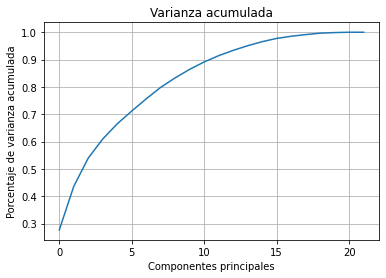

In [ ]:
# aca realizamos una curva de varianza explicada del PCA
pca_varianza = PCA(n_components=x.shape[1]).fit(StandardScaler().fit_transform(x))
plt.plot(np.cumsum(pca_varianza.explained_variance_/np.sum(pca_varianza.explained_variance_)))
plt.title('Varianza acumulada')
plt.xlabel('Componentes principales')
plt.ylabel('Porcentaje de varianza acumulada')
plt.grid()

In [ ]:
#@title Pregunta Abierta
#@markdown  ¿Como se relaciona el mejor número de componentes encontrado en los experimentos con la curva de varianza explicada? Explicar con base a los resultados, la grafica y la teoria
respuesta_3 = 'La grafica anterior constata la teoria, donde se plantea que a medida que se reducen las componentes nos encontramos con menor varianza del conjunto original. Dicha grafica explica el porque de los resultados anteriores ya que a partir de 10 componentes se encuentra asegurado el 90% de la varianza del conjunto original llegando a casi un 100% con 20 componentes(Mejor nro de componentes encontrado).' #@param {type:"string"}

ahora recordemos que el PCA tambien nos sirve para explorar y visualizar los datos en pocas dimensiones. En la siguiente celda vamos a visualizar nuestro conjunto de datos usando los dos primeros componentes principales

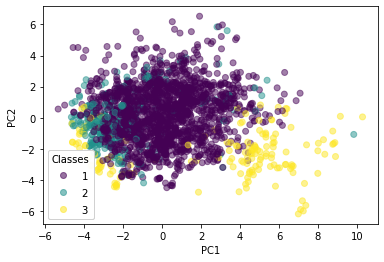

In [ ]:
data_to_plot = StandardScaler().fit_transform(X=x)
fig, ax = plt.subplots()
pca = PCA(n_components=2)
x_pc2 = pca.fit_transform(data_to_plot)
scatter= ax.scatter(x= x_pc2[:,0], y = x_pc2[:,1], c = y, alpha = 0.5, label = y)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [ ]:
#@title Pregunta Abierta
#@markdown Aunque PCA nos sirve para ver los datos en dimensiones menores a la base de datos original, sabiendo la varianza acumulada obtenida para 2 componentes principales ¿que tan cercana es la aproximación para este problema en específico?
respuesta_4 = 'Los resultados para 5,10,15 y 20 componentes fueron similares a los arrojados por el conjunto original de variables, sin embargo para dos componentes la proximacion difiere mucho del conjunto original' #@param {type:"string"}

### Ejercicio 3: Entrenamiento usando Discriminante de Fisher para extracción

En este ejercicio vamos a aplicar PCA para realizar la extracción de caracteristicas. Para ello tener en cuenta:

1. Vamos a usar el modulo [LinearDiscriminantAnalysis-LDA de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html). El cual ya se encuentra importado (se pueda acceder a el como `LinearDiscriminantAnalysis(....)`)
2. ¿También se estandarizar los datos?
3. Usar 5 particiones en la metodologia de validación
3. Usar la exactitud/accuracy como medida de error del modulo [metrics de sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
4. Vamos a calcular el costo computacional de aplicar la LDA.
5. Recordar que LDA se debe "ajustar" con el conjunto de entrenamiento. Pero la transformación se debe hacer para las particiones de entrenamiento y test.

In [ ]:
#@title Pregunta Abierta
#@markdown Explicar en sus palabras la principal ventaja que tiene LDA sobre PCA para resolver problemas de clasificación.
respuesta_5 = 'Mientras PCA busca direcciones de proyeccion que son eficientes para representar los datos, LDA busca direcciones que son eficientes para discriminacion, es decir que permiten una mejor separacion de las clases en el espacio de menor dimension. Adicionalmente, una de las ventajas es que el LDA es una tecnica supervisada, por tanto, tiene en cuenta las salidas del sistema  para hallar los mejores resultados mientras que el PCA es no supervisado y es necesario realizar otros experimentos para determinar la viabilidad de las componentes. PCA trata de maximizar la varianza mientras que LDA maximiza la separabilidad entre clases.' #@param {type:"string"}

In [ ]:
#ejercicio de código
def entrenamiento_lda_ext_caracteristicas(n_comp, X, Y):
    """
    Esta función realiza la reducción de la dimensionalidad sobre el conjunto de
    datos de entrenamiento, de acuerdo con las particiones especificadas usando PCA

    Parámetros:
    n_comp, int, Número de componentes para reducción
    n_sets,int, Número de particiones
    X: numpy Array de características
    Y: numpy Array  Vector de etiquetas

    Retorna: 
    ErrorValidacion: El valor medio de errores
    IC_Validacion: Intervalo de confianza
    T_ejec:  El  valor medio del tiempo de ejecución
    """
   

    #Implemetamos la metodología de validación 
    Errores = np.ones(5)
    times = np.ones(5)
    j = 0
    kf = KFold(n_splits = 5)
    for train_index, test_index in kf.split(X):  
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # ¿es necesario estandarizacion de datos?       
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        # dejar el nombre del objeto igual (lda)
        lda = LinearDiscriminantAnalysis(n_components= n_comp)
        # para calcular costo computacional
        tiempo_i = time.time()
        # es recomendable usar el metodo que ajusta y transforma
        X_train_lda = lda.fit_transform(X_train, y_train)
        # aca solo usar el metodo de transformar (ya que en el anterior el pca se ajusto)
        X_test_lda = lda.transform(X_test)
        # entrenar el modelo usando las caractieristicas transformadas por PCA
        clf = SVC(kernel="linear", C=1)
        clf.fit(X=X_train_lda, y=y_train)
        tiempo_o = time.time()-tiempo_i
        Errores[j] = accuracy_score(y_true=y_test, y_pred=clf.predict(X_test_lda))
        times[j] = tiempo_o
        j+=1


    return np.mean(times), np.mean(Errores), np.std(Errores)


In [ ]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio3", entrenamiento_lda_ext_caracteristicas)

TEST EXITOSO!


### Ejercicio 4 : Experimentar con Discriminante de Fisher

Usando las anteriores funciones vamos a realizar experimentos para evaluar la efectividad de PCA, para ello:

1. Utilizar una metodología cross-validation con 5 particiones.
2. Usar como parametros para los experimentos el número de características a extraer
3. Usar la función `entrenamiento_pca_ext_caracteristicas` para realizar la extración de características.
3. Vamos a retornar un DataFrame con las siguientes columnas:
    - CON_SEL (indicando si se uso selección de caracteristicas)
    - NUM_VAR (número de selección de caracteristicas)
    - ERROR_VALIDACION
    - IC_STD_VALIDACION
    - T_EJECUCION: tiempo de ejecucción
4. En la primera fila del dataframe vamos a incluir la evaluación del modelo SVM sin selección de características (usando la función creada en el primer ejercicio). 

In [ ]:
#ejercicio de código
def experimentar_LDA(n_feats, X, Y):
    """
    Esta función realiza la comparación del desempeño de RFE utilizando diferente 
    número de feats y particionando el conjunto de datos en diferente número de 
    subconjuntos

    Parámetros:
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas
    n_feats, Vector de números enteros que indica el número de características
              que debe utilizar el modelo
    n_sets, Vector de números enteros que indica el número de particiones

    Retorna:  
    - DataFrame con las columnas: DESCRIPCION, ERROR_VALIDACION, IC_STD_VALIDACION, 
    y T_EJECUCION. 

    """
    """
    Esta función realiza la comparación del desempeño de RFE utilizando diferente 
    número de feats y particionando el conjunto de datos en diferente número de 
    subconjuntos

    Parámetros:
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas
    n_feats, Vector de números enteros que indica el número de características
              que debe utilizar el modelo
    n_sets, Vector de números enteros que indica el número de particiones

    Retorna:  
    - DataFrame con las columnas: DESCRIPCION, ERROR_VALIDACION, IC_STD_VALIDACION, 
    y T_EJECUCION. 

    """
    df = pd.DataFrame()
    idx = 0
    split_number = 5
    #Sin selección de características
    error,ic_error,t_ex = entrenamiento_sin_seleccion_caracteristicas(split_number, X,Y)  
    df.loc[idx,'CON_SEL'] = 'NO'
    df.loc[idx,'NUM_VAR'] = X.shape[1] # se usan todas las caracteristicas
    df.loc[idx,'ERROR_VALIDACION'] = error
    df.loc[idx,'IC_STD_VALIDACION'] = ic_error
    df.loc[idx,'T_EJECUCION'] = t_ex
    idx+=1
    print("termina experimento sin selección")
    #Con selección de características
    
    for f in n_feats:
        #Implemetamos la metodología de validación 
        error, ic_error, t_ex = entrenamiento_lda_ext_caracteristicas(n_comp=f, X=x,Y=y)
        df.loc[idx,'CON_SEL'] = 'SI'
        df.loc[idx,'NUM_VAR'] = error
        df.loc[idx,'ERROR_VALIDACION'] = error
        df.loc[idx, 'IC_STD_VALIDACION'] = ic_error
        df.loc[idx, 'T_EJECUCION'] = t_ex
        idx+=1
    return df


In [ ]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio4", experimentar_LDA)

termina experimento sin selección
TEST EXITOSO!


In [ ]:
experimentar_LDA(n_feats=[1,2], X= x, Y = y)

termina experimento sin selección


,CON_SEL,NUM_VAR,ERROR_VALIDACION,IC_STD_VALIDACION,T_EJECUCION
0,NO,22.000000,0.932288,0.042333,0.033514
1,SI,0.033285,0.033285,0.835434,0.106180
2,SI,0.032643,0.032643,0.923810,0.035584


In [ ]:
#@title Pregunta Abierta
#@markdown  ¿que diferencias existen entre los métodos de selección de características y los métodos de extracción de características vistos en la anterior sesión? Explicar
respuesta_6 = 'La principal diferencia es que en la seleccion de caracteristicas se busca reducir la dimensionalidad utilizando solo un subconjunto de las caraceristicas originales, mientras que en la extraccion de caracteristicas se realizan transformaciones a los datos originales para intentar describir su comportamiento con menos variables.' #@param {type:"string"}

In [ ]:
GRADER.check_tests()

Todo se ve ok. Asegurate de responder las preguntas abiertas y envia le archivo al formulario ¡buen trabajo!


In [ ]:
#@title Integrantes
codigo_integrante_1 ='1035439685' #@param {type:"string"}
codigo_integrante_2 = '1020485954'  #@param {type:"string"}

----
esta linea de codigo va fallar, es de uso exclusivo de los profesores


In [ ]:
GRADER.grade()

uso del docente
